In [16]:
!pip install requests_html

Defaulting to user installation because normal site-packages is not writeable


In [18]:
from yahoo_fin.stock_info import get_data
from datetime import datetime, timedelta
from statsmodels.stats.stattools import durbin_watson
import seaborn as sns
from statsmodels.stats.diagnostic import het_white
from statsmodels.stats.diagnostic import het_breuschpagan
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_predict
import warnings
import statsmodels.api as sm
import numpy as np
import pandas as pd
from scipy.stats import shapiro
from scipy.stats import anderson
from sklearn.metrics import r2_score
from tqdm import tqdm 
warnings.filterwarnings("ignore")

ModuleNotFoundError: No module named 'yahoo_fin'

In [14]:
stock = 'BTC-USD'
resolution = '1d'
end_date = datetime.now()
start_date = "2014-09-15"

NameError: name 'datetime' is not defined

In [12]:
CL_df = get_data(stock, start_date=start_date, end_date=end_date, interval=resolution, index_as_date=False)
CL_df.head()

,date,open,high,low,close,adjclose,volume,ticker
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800,BTC-USD
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200,BTC-USD
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700,BTC-USD
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600,BTC-USD
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100,BTC-USD


In [13]:
CL_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3653 entries, 0 to 3652
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      3653 non-null   datetime64[ns]
 1   open      3653 non-null   float64       
 2   high      3653 non-null   float64       
 3   low       3653 non-null   float64       
 4   close     3653 non-null   float64       
 5   adjclose  3653 non-null   float64       
 6   volume    3653 non-null   int64         
 7   ticker    3653 non-null   object        
dtypes: datetime64[ns](1), float64(5), int64(1), object(1)
memory usage: 228.4+ KB


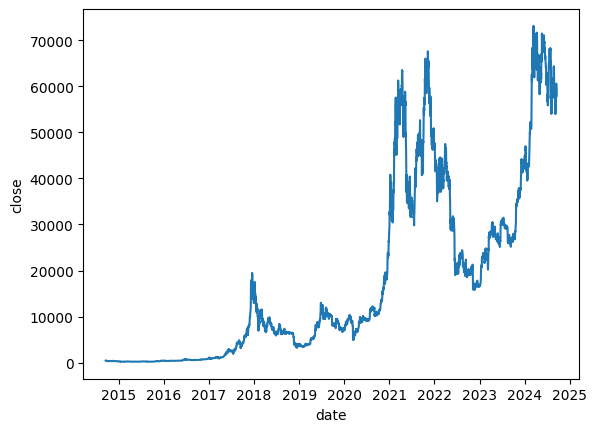

In [14]:
sns.lineplot(data=CL_df, x=CL_df.date, y=CL_df.close);

In [15]:
CL_df.describe()

,date,open,high,low,close,adjclose,volume
count,3653,3653.000000,3653.000000,3653.000000,3653.000000,3653.000000,3.653000e+03
mean,2019-09-17 00:00:00,17794.338264,18198.145762,17362.210558,17808.927202,17808.927202,1.761129e+10
min,2014-09-17 00:00:00,176.897003,211.731003,171.509995,178.102997,178.102997,5.914570e+06
25%,2017-03-18 00:00:00,1156.729980,1184.979980,1124.589966,1165.199951,1165.199951,2.896340e+08
50%,2019-09-17 00:00:00,9151.183594,9302.501953,8958.190430,9162.917969,9162.917969,1.379783e+10
75%,2022-03-18 00:00:00,29180.019531,29560.966797,28782.330078,29200.740234,29200.740234,2.857479e+10
max,2024-09-16 00:00:00,73079.375000,73750.070312,71334.093750,73083.500000,73083.500000,3.509679e+11
std,NaN,19607.899942,20045.320987,19126.168014,19615.176633,19615.176633,1.917553e+10


In [16]:
adf_result = adfuller(CL_df.close)
print('ADF Statistic: %f' % adf_result[0])
print('p-value: %f' % adf_result[1])
if 0.05 < adf_result[1]:
    print('La serie tiene una raíz unitaria y no es estacionaria (no se rechaza H0)')
else:
    print('La serie no tiene una raíz unitaria y es estacionaria (se rechaza H0)')

ADF Statistic: -1.059683
p-value: 0.730879
La serie tiene una raíz unitaria y no es estacionaria (no se rechaza H0)


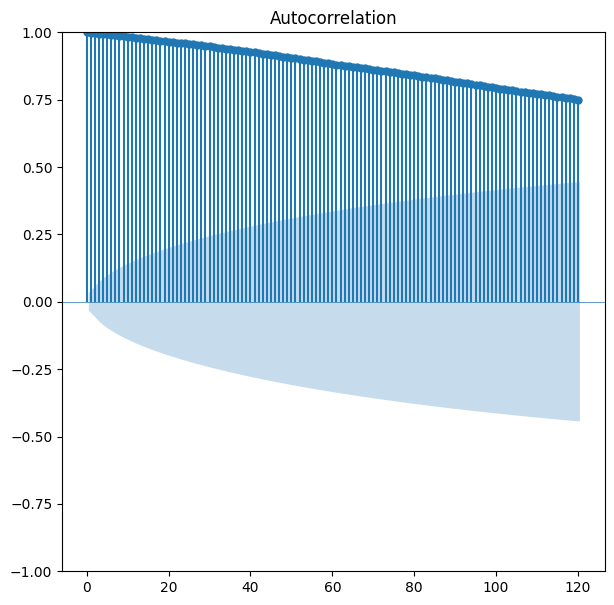

In [289]:
plt.rcParams.update({'figure.figsize': (7,7)})
plot_acf(CL_df.close, lags=120, linewidth=0.5)
plt.show()

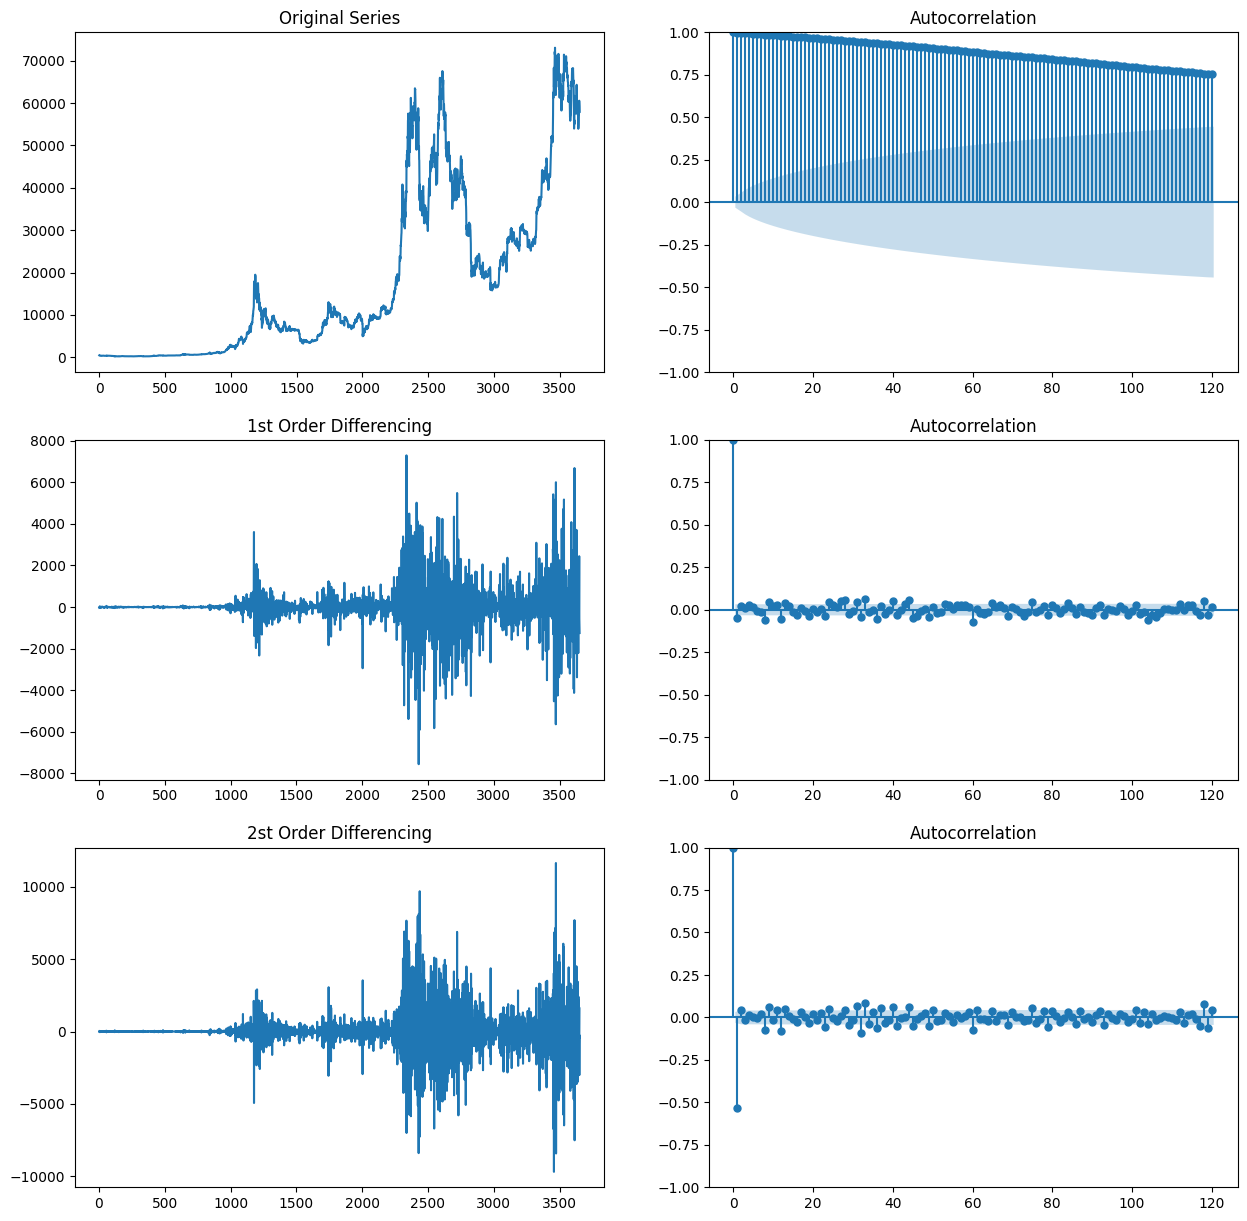

In [18]:
plt.rcParams.update({'figure.figsize': (15,15)})

fig, axes = plt.subplots(3, 2, sharex=False)
axes[0, 0].plot(CL_df.close); axes[0, 0].set_title('Original Series')
plot_acf(CL_df.close, ax=axes[0, 1], lags = 120);

axes[1, 0].plot(CL_df.close.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(CL_df.close.diff().dropna(), ax=axes[1, 1], lags = 120);

axes[2, 0].plot(CL_df.close.diff().diff()); axes[2, 0].set_title('2st Order Differencing')
plot_acf(CL_df.close.diff().diff().dropna(), ax=axes[2, 1], lags = 120);

In [19]:
n_AAPL = len(CL_df.close); n_test = 28 # This can be changed
train_size = n_AAPL - n_test
train_size

3625

In [20]:
train = CL_df.close[:train_size]
dates_train = CL_df.date[:train_size]
test_4w = CL_df.close[train_size:train_size + n_test] 
dates_4w = CL_df.date[train_size:train_size + n_test] 
print("train:", train.shape)
print("test_4w:", test_4w.shape)

train: (3625,)
test_4w: (28,)


In [21]:
train_df = CL_df[["close"]][:train_size]
test_4w_df = CL_df[["close"]][train_size:train_size + n_test] 
test_4w_df.head()

,close
3625,59012.792969
3626,61175.191406
3627,60381.914062
3628,64094.355469
3629,64178.992188


In [22]:
best_aic = np.inf
best_bic = np.inf

best_order = None
best_mdl = None

pq_rng = range(5)
d_rng  = range(3)

lags = []
dif = []
ave = []
aic = []
bic = []
HQIC = []

for i in pq_rng:
    for d in d_rng:
        for j in pq_rng:
            try:
                # print(i, d, j)
                tmp_mdl = ARIMA(train, order=(i,d,j)).fit()
                lags.append(i)
                dif.append(d)
                ave.append(j)
                aic.append(tmp_mdl.aic)
                bic.append(tmp_mdl.bic)
                HQIC.append(tmp_mdl.hqic)
            except: continue

results = pd.DataFrame({
    'lags': lags,
    'dif': dif,
    'ave': ave,
    'aic': aic,
    'bic': bic,
    'hqic': HQIC
})

In [23]:
results.sort_values(by='hqic', ascending=True)

,lags,dif,ave,aic,bic,hqic
69,4,1,4,59392.579066,59448.337069,59412.443235
26,1,2,1,59407.868665,59426.453838,59414.489853
12,0,2,2,59408.239441,59426.824614,59414.860628
52,3,1,2,59401.947175,59439.119177,59415.189955
37,2,1,2,59404.236573,59435.213241,59415.272222
...,...,...,...,...,...,...
4,0,0,4,68385.387659,68422.561317,68398.630842
3,0,0,3,71582.647542,71613.625589,71593.683528
2,0,0,2,73195.395301,73220.177739,73204.224089
1,0,0,1,77051.096306,77069.683135,77057.717898


## Modelo 1

In [24]:
best_order = (1,2,1)
model = ARIMA(train, order=best_order)
model_fit = model.fit()

In [25]:
def forecast_accuracy(forecast, actual, str_name):
    
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual)) # MAPE
    mae = np.mean(np.abs(forecast - actual))                 # MAE
    rmse = np.mean((forecast - actual)**2)**.5               # RMSE
    mse = np.mean((forecast - actual)**2)                    # MSE
    r2 = r2_score(forecast, actual)
    
    df_acc = pd.DataFrame({'MAE': [mae],
                           'MSE': [mse],
                           'MAPE': [mape],
                           'RMSE': [rmse],
                           'R2': [r2]},
                          index=[str_name])
    
    return df_acc

In [26]:
def arima_rolling(history, test, order):
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=order)
        model_fit = model.fit()
        output = model_fit.forecast()
        yhat = output[0]
        predictions.append(yhat)
        obs = test[t]
        history.append(obs)
        print('predicted=%f, expected=%f' % (yhat, obs))
        
    return predictions

In [27]:
test_4wl = test_4w.tolist()
yhat_4w  = arima_rolling(train.tolist(), test_4wl, order = (1,2,1))

predicted=59458.775549, expected=59012.792969
predicted=59054.611978, expected=61175.191406
predicted=61080.611496, expected=60381.914062
predicted=60441.564249, expected=64094.355469
predicted=63914.298510, expected=64178.992188
predicted=64193.038772, expected=64333.542969
predicted=64343.914238, expected=62880.660156
predicted=62976.136364, expected=59504.132812
predicted=59694.851390, expected=59027.625000
predicted=59068.729813, expected=59388.179688
predicted=59387.006240, expected=59119.476562
predicted=59150.107271, expected=58969.898438
predicted=58994.439337, expected=57325.488281
predicted=57425.127106, expected=59112.480469
predicted=59037.343600, expected=57431.023438
predicted=57535.945163, expected=57971.539062
predicted=57959.673974, expected=56160.488281
predicted=56272.917082, expected=53948.753906
predicted=54078.533280, expected=54139.687500
predicted=54145.363877, expected=54841.566406
predicted=54821.049546, expected=57019.535156
predicted=56924.523874, expected=5

In [28]:
forecast_accuracy(np.array(test_4wl), np.array(yhat_4w), "week 1")

,MAE,MSE,MAPE,RMSE,R2
week 1,1179.990308,2.348647e+06,0.019999,1532.529689,0.667912


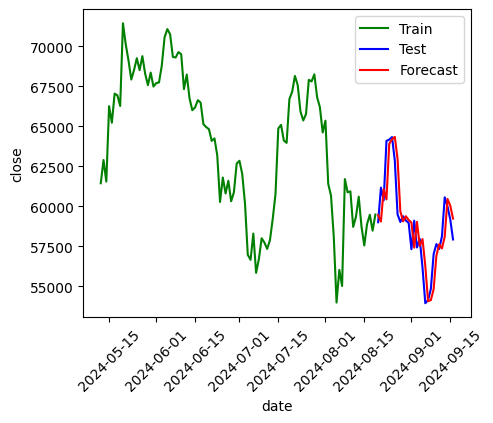

In [30]:
plt.rcParams.update({'figure.figsize': (5, 4)})
ax = sns.lineplot(x=dates_train[-100:], y=train[-100:], label="Train", color='g')
sns.lineplot(x=dates_4w, y=test_4wl, label="Test", color='b')
sns.lineplot(x=dates_4w, y=yhat_4w, label="Forecast", color='r')
plt.xticks(rotation=45)
plt.show()

In [31]:
df_cor = pd.DataFrame({
    'Obs': test_4wl,
    'pred': yhat_4w
})
df_cor.corr(method='spearman')

,Obs,pred
Obs,1.000000,0.809524
pred,0.809524,1.000000


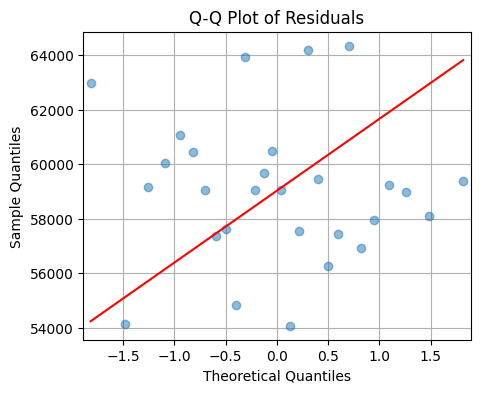

In [32]:
plt.rcParams.update({'figure.figsize': (5, 4)})
residuos = pd.DataFrame(list(set(yhat_4w) - set(test_4wl)))
fig = sm.qqplot(residuos, line='s', alpha=0.5, lw=2)
plt.title('Q-Q Plot of Residuals')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')
plt.grid(True)
plt.show()

Text(0, 0.5, 'Frecuencia')

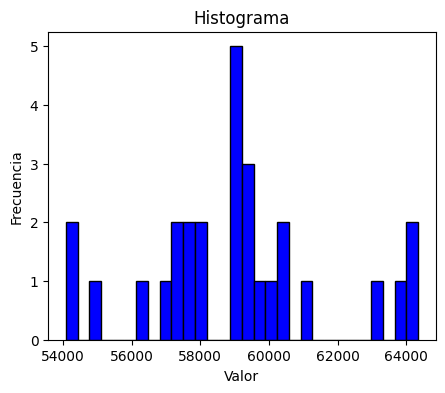

In [33]:
plt.hist(residuos, bins=30, color='blue', edgecolor='black')
plt.title('Histograma')
plt.xlabel('Valor')
plt.ylabel('Frecuencia')

In [34]:
stat, p = shapiro(residuos)
print('Statistics=%.3f, p=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
    print('La muestra se aproxima a una distribución gaussiana (no se rechaza H0)')
else:
    print('La muestra no se aproxima a una distribución gaussiana (se rechaza H0)')

Statistics=0.949, p=0.186
La muestra se aproxima a una distribución gaussiana (no se rechaza H0)


In [35]:
adf_result = adfuller(residuos[0])
print('ADF Statistic: %f' % adf_result[0])
print('p-value: %f' % adf_result[1])
if 0.05 < adf_result[1]:
    print('Los residuos no son estacionarios (no se rechaza H0)')
else:
    print('Los residuos son estacionarios (se rechaza H0)')

ADF Statistic: -4.410288
p-value: 0.000285
Los residuos son estacionarios (se rechaza H0)


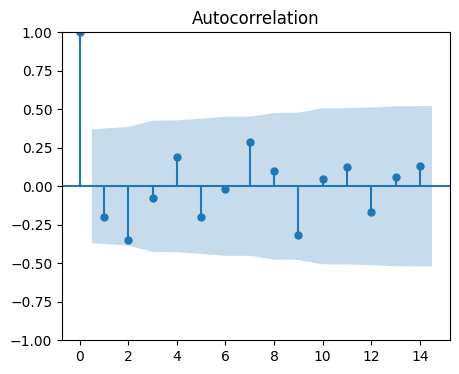

In [36]:
plot_acf(residuos[0])
plt.show()

In [37]:
ljung_box = acorr_ljungbox(residuos, lags=[10], return_df=True)

print('LB Statistic: %f' % ljung_box['lb_stat'][10])
print('p-value: %f' % ljung_box['lb_pvalue'][10])

p_value = ljung_box['lb_pvalue'][10]
if p_value < 0.05:
    print('Los residuos están correlacionados (se rechaza H0)')
else:
    print('Los residuos no están correlacionados (no se rechaza H0)')

LB Statistic: 16.405455
p-value: 0.088599
Los residuos no están correlacionados (no se rechaza H0)


In [38]:
dw_test = durbin_watson(residuos)
print(f'Estadístico de Durbin-Watson: {dw_test[0]}')

Estadístico de Durbin-Watson: 0.004607991513513314


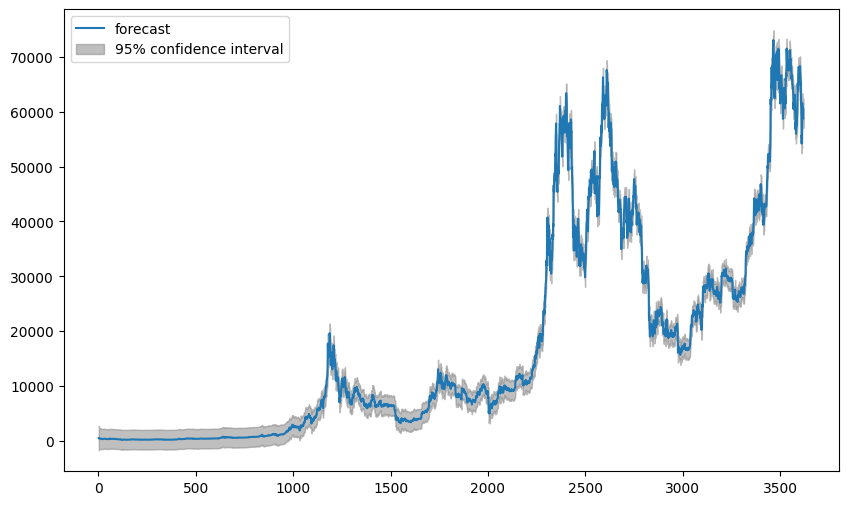

In [234]:
plt.rcParams.update({'figure.figsize': (10,6)})
fig, ax = plt.subplots();
plot_predict(model_fit, 2, ax=ax);
plt.show();

## Modelo 2

In [39]:
best_order = (4,2,4)
model2 = ARIMA(train, order=best_order)
model_fit = model2.fit()

In [40]:
test_4wl = test_4w.tolist()
yhat_4w  = arima_rolling(train.tolist(), test_4wl, order = (4,2,4))

predicted=59378.885127, expected=59012.792969
predicted=58963.295957, expected=61175.191406
predicted=61216.524590, expected=60381.914062
predicted=60474.521792, expected=64094.355469
predicted=63767.072322, expected=64178.992188
predicted=64184.752887, expected=64333.542969
predicted=64461.657477, expected=62880.660156
predicted=62931.915896, expected=59504.132812
predicted=59641.511608, expected=59027.625000
predicted=59126.297064, expected=59388.179688
predicted=59459.712347, expected=59119.476562
predicted=59113.103855, expected=58969.898438
predicted=59028.721371, expected=57325.488281
predicted=57506.759671, expected=59112.480469
predicted=0.000000, expected=57431.023438
predicted=57535.071804, expected=57971.539062
predicted=58019.012206, expected=56160.488281
predicted=56307.052904, expected=53948.753906
predicted=54032.479601, expected=54139.687500
predicted=54048.716874, expected=54841.566406
predicted=54799.343067, expected=57019.535156
predicted=56888.720296, expected=57648

In [278]:
forecast_accuracy(np.array(test_4wl), np.array(yhat_4w), "week 1")

,MAE,MSE,MAPE,RMSE,R2
week 1,3147.081554,1.199144e+08,inf,10950.544036,-16.273104


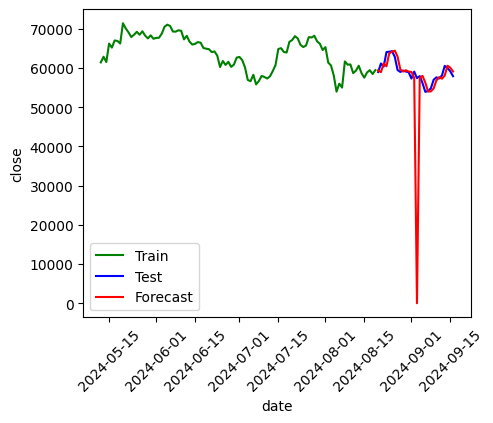

In [41]:
ax = sns.lineplot(x=dates_train[-100:], y=train[-100:], label="Train", color='g')
sns.lineplot(x=dates_4w, y=test_4wl, label="Test", color='b')
sns.lineplot(x=dates_4w, y=yhat_4w, label="Forecast", color='r')
plt.xticks(rotation=45)
plt.show()

In [42]:
df_cor = pd.DataFrame({
    'Obs': test_4wl,
    'pred': yhat_4w
})
df_cor.corr(method='spearman')

,Obs,pred
Obs,1.00000,0.80624
pred,0.80624,1.00000


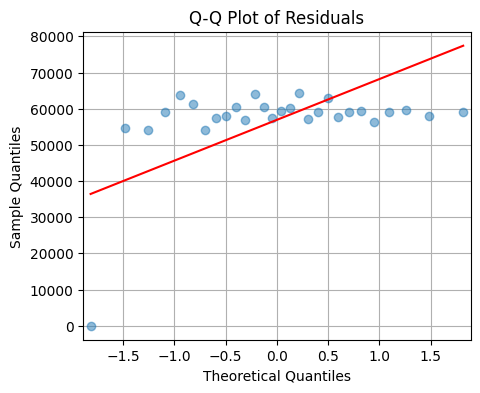

In [43]:
plt.rcParams.update({'figure.figsize': (5, 4)})
residuos = pd.DataFrame(list(set(yhat_4w) - set(test_4wl)))
fig = sm.qqplot(residuos, line='s', alpha=0.5, lw=2)
plt.title('Q-Q Plot of Residuals')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')
plt.grid(True)
plt.show()

Text(0, 0.5, 'Frecuencia')

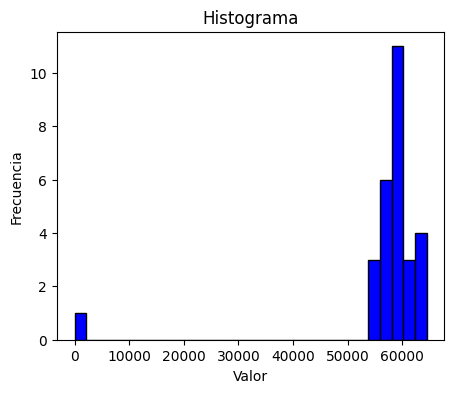

In [44]:
plt.hist(residuos, bins=30, color='blue', edgecolor='black')
plt.title('Histograma')
plt.xlabel('Valor')
plt.ylabel('Frecuencia')

In [45]:
stat, p = shapiro(residuos)
print('Statistics=%.3f, p=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
    print('La muestra se aproxima a una distribución gaussiana (no se rechaza H0)')
else:
    print('La muestra no se aproxima a una distribución gaussiana (se rechaza H0)')

Statistics=0.395, p=0.000
La muestra no se aproxima a una distribución gaussiana (se rechaza H0)


In [46]:
adf_result = adfuller(residuos[0])
print('ADF Statistic: %f' % adf_result[0])
print('p-value: %f' % adf_result[1])
if 0.05 < adf_result[1]:
    print('Los residuos no son estacionarios (no se rechaza H0)')
else:
    print('Los residuos son estacionarios (se rechaza H0)')

ADF Statistic: -20.763599
p-value: 0.000000
Los residuos son estacionarios (se rechaza H0)


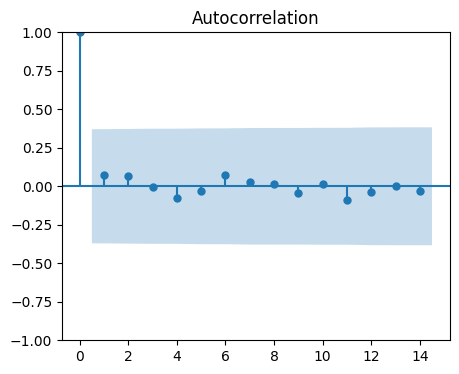

In [47]:
plot_acf(residuos[0])
plt.show()

In [48]:
ljung_box = acorr_ljungbox(residuos, lags=[10], return_df=True)

print('LB Statistic: %f' % ljung_box['lb_stat'][10])
print('p-value: %f' % ljung_box['lb_pvalue'][10])

p_value = ljung_box['lb_pvalue'][10]
if p_value < 0.05:
    print('Los residuos están correlacionados (se rechaza H0)')
else:
    print('Los residuos no están correlacionados (no se rechaza H0)')

LB Statistic: 0.901390
p-value: 0.999893
Los residuos no están correlacionados (no se rechaza H0)


In [49]:
dw_test = durbin_watson(residuos)
print(f'Estadístico de Durbin-Watson: {dw_test[0]}')

Estadístico de Durbin-Watson: 0.035644574825263946


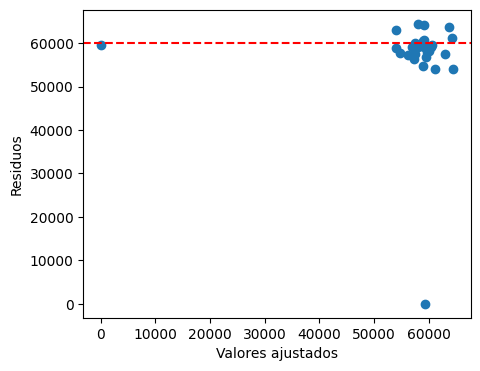

In [50]:
plt.scatter(yhat_4w, residuos)
plt.axhline(y=60000, color='r', linestyle='--')
plt.xlabel('Valores ajustados')
plt.ylabel('Residuos')
plt.show()